In [24]:
import pandas as pd
import numpy as np
import glob
import nibabel as nib
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score

In [25]:
def grab_stat_files(dir:str):
    # Set directory containing the contrast files
    dir = dir
    # Get list of all .nii.gz files in the directory
    files = glob.glob(dir)
    # Exclude those with missing dprime values
    files = [f for f in files if all(x not in f for x in ['028','522'])]
    # Separate files into HC and SCZ groups based on filename prefixes
    HC = []
    SCZ = []
    for f in files: 
        if f.split('/')[-1].startswith('0'):
            HC.append(f)
        if f.split('/')[-1].startswith('5'):
            SCZ.append(f)
    # Sort the lists to maintain consistent order
    return sorted(HC), sorted(SCZ)

In [26]:
c = 'contrast-2v1'
thr = 'thr2.81'
thr_hc, thr_scz = grab_stat_files(f'/BICNAS2/tuominen/ANM2_SCZ/anm_files/fz_maps/{c}/{thr}/Fz-maps/*.nii.gz')

In [27]:
def extract_pca_values(file_list):
    pca_values = []
    for file in file_list:
        img = nib.load(file)
        data = img.get_fdata()
        flattened_data = data.flatten()
        #print(flattened_data.shape)
        pca_values.append(flattened_data)
        X = np.vstack(pca_values)
    return X

In [28]:
pca_array = extract_pca_values(thr_hc + thr_scz)

In [29]:
standard_pca_array = StandardScaler().fit_transform(pca_array)

In [30]:
pca = PCA(n_components=0.95)

In [31]:
X_pca = pca.fit_transform(standard_pca_array)

In [32]:
pca.n_components_

13

In [33]:
X_pca.shape

(56, 13)

In [41]:
dprime_df = pd.read_csv('/BICNAS2/tuominen/ANM2_SCZ/code/2back_dprime_allsubjects.csv', index_col=0)
# Filter to match subjects in your fMRI data (excluding 028 and 522)
dprime_df = dprime_df[~dprime_df['Subject'].isin([28, 522])]
# Sort by subject to match the order of your fMRI files
dprime_df = dprime_df.sort_values('Subject').reset_index(drop=True)
dprime_df

,Subject,BlockCondition,run,n_hit,n_miss,n_fa,n_cr,d_prime
0,2,2-back,2.0,9.666667,0.333333,0.333333,13.666667,3.213993
1,4,2-back,2.0,10.000000,0.000000,0.000000,14.000000,3.447597
2,5,2-back,2.0,9.333333,0.666667,2.000000,12.000000,2.542582
3,6,2-back,2.0,9.666667,0.333333,0.000000,14.000000,3.326496
4,8,2-back,2.0,7.000000,3.000000,0.000000,14.000000,2.404727
5,10,2-back,2.0,10.000000,0.000000,0.000000,14.000000,3.447597
6,13,2-back,2.0,10.000000,0.000000,0.000000,14.000000,3.447597
7,17,2-back,2.0,8.333333,1.666667,0.333333,13.666667,2.786809
8,20,2-back,2.0,9.000000,1.000000,1.333333,12.666667,2.588688
9,21,2-back,2.0,9.000000,1.000000,0.000000,14.000000,3.084295


In [38]:
# Extract d-prime values as the behavioral outcome variable
y_behavior = dprime_df['d_prime'].values
print(f"Number of subjects: {len(y_behavior)}")
print(f"X_pca shape: {X_pca.shape}")
print(f"y_behavior shape: {y_behavior.shape}")

Number of subjects: 56
X_pca shape: (56, 13)
y_behavior shape: (56,)


In [44]:
# ---------------------------------------------------------
# 1. Setup Data
# ---------------------------------------------------------
# X_pca: Your PCA-transformed data from the previous step (Shape: 56 x 13)
# y_behavior: Your behavioral scores (Shape: 56,)
# Ensure y is a numpy array
y_behavior = np.array(y_behavior)

# ---------------------------------------------------------
# 2. Define Hyperparameters
# ---------------------------------------------------------
# The paper searched alphas from 10^-5 to 10^5 in logarithmic steps
alphas = np.logspace(-5, 5, 11)

# ---------------------------------------------------------
# 3. Nested Leave-One-Out Cross-Validation
# ---------------------------------------------------------
# Store predictions and actual values
y_pred_all = []
y_true_all = []
coefficients_all = [] # Store weights if you want to project back later

# Outer Loop: Leave one subject out for testing [cite: 235, 473]
outer_cv = LeaveOneOut()

print(f"Starting Nested LOOCV on {len(y_behavior)} subjects...")

for train_index, test_index in outer_cv.split(X_pca):
    # Split data into training (N-1) and testing (1) sets
    X_train, X_test = X_pca[train_index], X_pca[test_index]
    y_train, y_test = y_behavior[train_index], y_behavior[test_index]

    # Inner Loop: Optimize Alpha using the training set
    # RidgeCV performs efficient LOOCV automatically
    inner_model = RidgeCV(alphas=alphas)
    inner_model.fit(X_train, y_train)
   
    # The best alpha found for this fold
    best_alpha = inner_model.alpha_
    print (f'Fold {train_index[0]}: Best alpha = {best_alpha}')
   
    # Predict the left-out subject [cite: 479, 480]
    prediction = inner_model.predict(X_test)
   
    # Store results
    y_pred_all.append(prediction[0])
    y_true_all.append(y_test[0])
    coefficients_all.append(inner_model.coef_)

# ---------------------------------------------------------
# 4. Evaluation
# ---------------------------------------------------------
# Convert lists to arrays
y_pred_all = np.array(y_pred_all)
y_true_all = np.array(y_true_all)

# Calculate R-squared correlation between predicted and observed scores [cite: 475]
# Note: The paper calculates R^2 as: 1 - sum((y_true - y_pred)^2) / sum((y_true - mean(y_true))^2)
r2 = r2_score(y_true_all, y_pred_all)

print(f"Prediction Performance (R^2): {r2:.4f}")

# Check the correlation (Pearson r) as a secondary metric
correlation = np.corrcoef(y_true_all, y_pred_all)[0, 1]
print(f"Correlation (r): {correlation:.4f}")


Starting Nested LOOCV on 56 subjects...
Fold 1: Best alpha = 100000.0
Fold 0: Best alpha = 100000.0
Fold 0: Best alpha = 100000.0
Fold 0: Best alpha = 100000.0
Fold 0: Best alpha = 100000.0
Fold 0: Best alpha = 100000.0
Fold 0: Best alpha = 100000.0
Fold 0: Best alpha = 100000.0
Fold 0: Best alpha = 100000.0
Fold 0: Best alpha = 100000.0
Fold 0: Best alpha = 100000.0
Fold 0: Best alpha = 100000.0
Fold 0: Best alpha = 100000.0
Fold 0: Best alpha = 100000.0
Fold 0: Best alpha = 100000.0
Fold 0: Best alpha = 100000.0
Fold 0: Best alpha = 100000.0
Fold 0: Best alpha = 100000.0
Fold 0: Best alpha = 100000.0
Fold 0: Best alpha = 100000.0
Fold 0: Best alpha = 100000.0
Fold 0: Best alpha = 100000.0
Fold 0: Best alpha = 100000.0
Fold 0: Best alpha = 100000.0
Fold 0: Best alpha = 100000.0
Fold 0: Best alpha = 100000.0
Fold 0: Best alpha = 100000.0
Fold 0: Best alpha = 100000.0
Fold 0: Best alpha = 100000.0
Fold 0: Best alpha = 100000.0
Fold 0: Best alpha = 100000.0
Fold 0: Best alpha = 100000.0


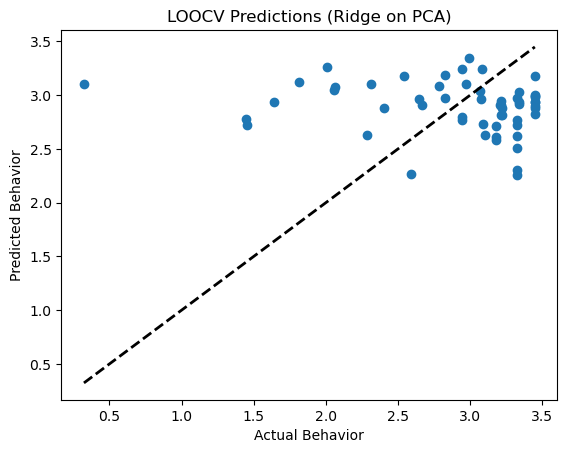

In [43]:
import matplotlib.pyplot as plt
plt.scatter(y_true_all, y_pred_all) 
plt.plot([y_true_all.min(), y_true_all.max()], [y_true_all.min(), y_true_all.max()], 'k--', lw=2) # Identity line 
plt.xlabel('Actual Behavior') 
plt.ylabel('Predicted Behavior') 
plt.title('LOOCV Predictions (Ridge on PCA)') 
plt.show()